In [86]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

In [87]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [88]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
experiment = "Lung"
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4', 'F7']
datasets = [f'{core}_{i}' for core in cores for i in range(1,5)]
# datasets = ['E6_1', 'E6_2', 'E6_3']

# Load data

In [90]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [91]:
adatas = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    # df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
    #     df_morph["area"], axis=0
    # )
    pseudo_count=1
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+pseudo_count)/(np.percentile(data_all,50,axis=1,keepdims=True)+pseudo_count)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_IMC.merge(df_intensity_TS, on="Id")
    df.set_index("Id", inplace=True)
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset B5_1
Sucessfully read dataset B5_2


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset B5_3
B5_4 cannot be read
Sucessfully read dataset C6_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset C6_2
Sucessfully read dataset C6_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset C6_4
Sucessfully read dataset D4_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset D4_2
Sucessfully read dataset D4_3
D4_4 cannot be read


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset E4_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset E4_2


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset E4_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset E4_4
Sucessfully read dataset E6_1
Sucessfully read dataset E6_2


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the fu

Sucessfully read dataset E6_3
E6_4 cannot be read
Sucessfully read dataset F4_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset F4_2
Sucessfully read dataset F4_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


F4_4 cannot be read
Sucessfully read dataset F7_1


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset F7_2
Sucessfully read dataset F7_3


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset F7_4


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/1322375014.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
IMC_markers = adata.var_names[:22]
SIMS_masses = df_intensity_TS.columns.tolist()[1:]

In [8]:
IMC_markers

Index(['CD11b', 'CD11c', 'CD20', 'CD3', 'CD31', 'CD4', 'CD44', 'CD45RA',
       'CD45RO', 'CD68', 'CD8', 'COL1', 'DNA1', 'DNA2', 'ECadherin', 'FoxP3',
       'GranzymeB', 'HistoneH3', 'Ki67', 'PanKeratin', 'SMA', 'Vimentin', '1'],
      dtype='object')

In [9]:
IMC_markers = IMC_markers.drop(["CD11b", "CD11c", "DNA1", "DNA2", "HistoneH3"])

In [10]:
# masks = get_masks(data_dir / "masks")

# for dataset in datasets:
#     adata_subset = adata[adata.obs.Dataset == dataset, :]
#     mask = masks[experiment + '_' + dataset]
    
#     # Get label2cell dict
#     cell_id =  adata_subset.obs.Cell.to_list()
#     mask_cell = np.where(np.isin(mask, cell_id), mask, 0)

# IMC cell phenotype

In [101]:
adata_IMC = adata[:, IMC_markers]
sc.pp.scale(adata_IMC, max_value=4)

# first store the raw data 
adata_IMC.raw = adata_IMC

# run combat
sc.pp.combat(adata_IMC, key='Core')

Standardizing Data across genes.

Found 7 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [102]:
adata_IMC.var_names

Index(['CD20', 'CD3', 'CD31', 'CD4', 'CD44', 'CD45RA', 'CD45RO', 'CD68', 'CD8',
       'COL1', 'ECadherin', 'FoxP3', 'GranzymeB', 'Ki67', 'PanKeratin', 'SMA',
       'Vimentin', '1'],
      dtype='object')

# SIMS data

In [110]:
# Get SIMS data
adata_SIMS = adata[:, SIMS_masses]

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


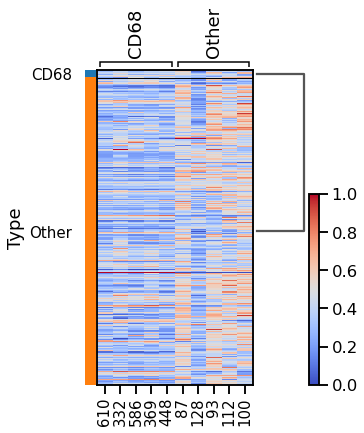

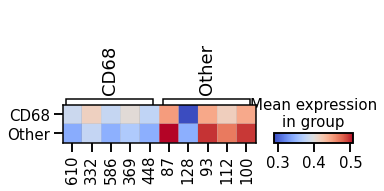

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


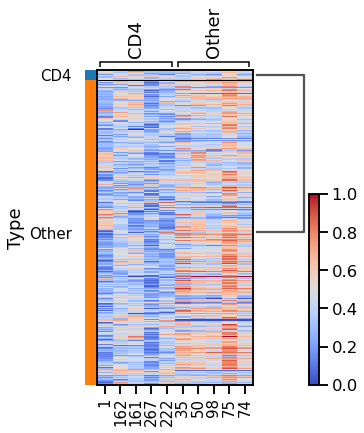

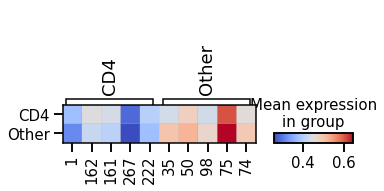

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


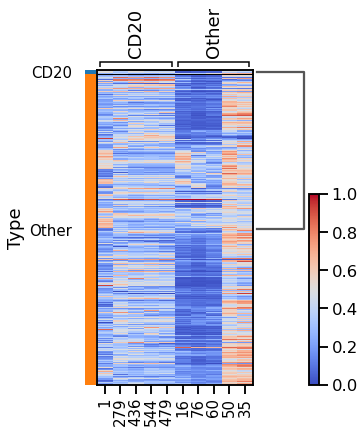

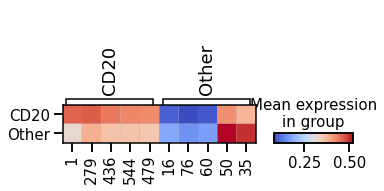

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


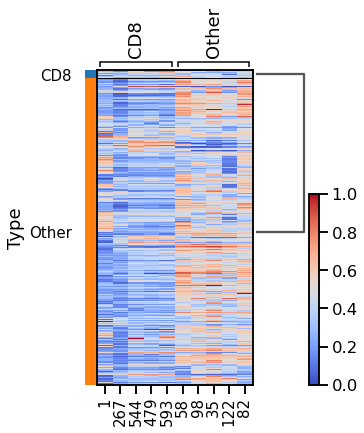

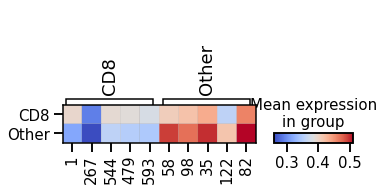

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


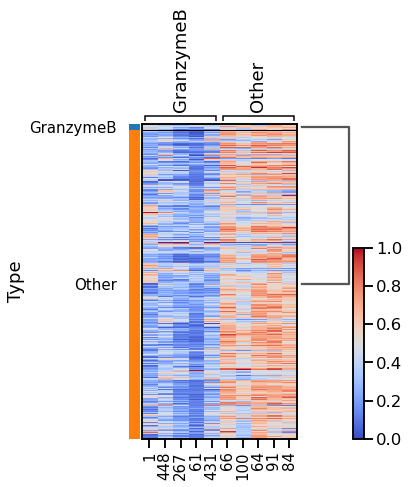

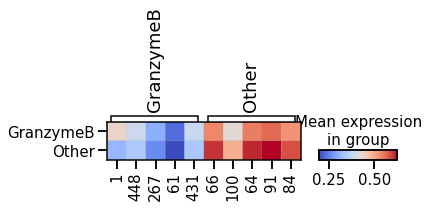

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


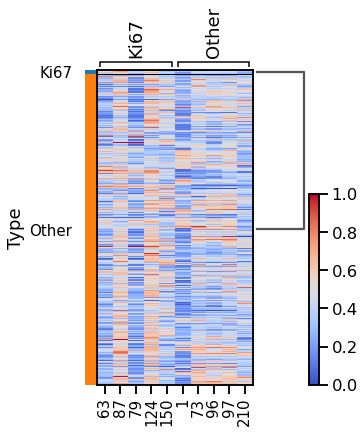

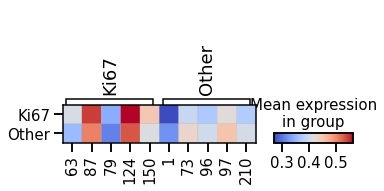

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


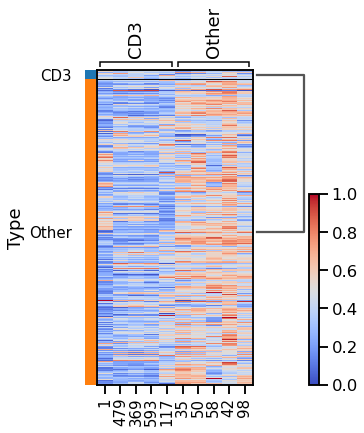

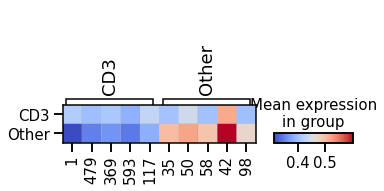

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


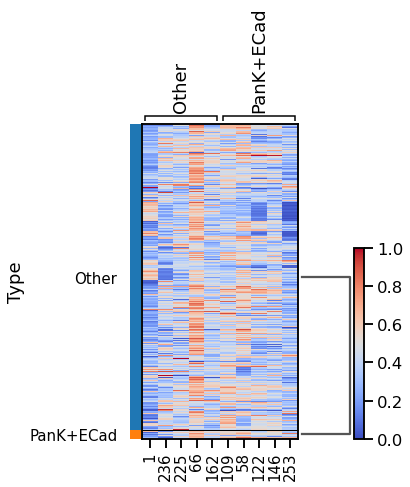

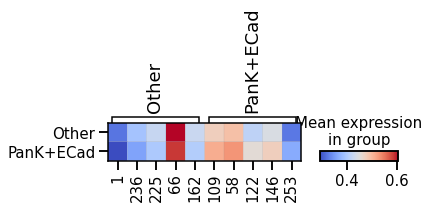

ranking genes


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/3918075123.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SIMS.obs['Type'] = df.Type.tolist()
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`


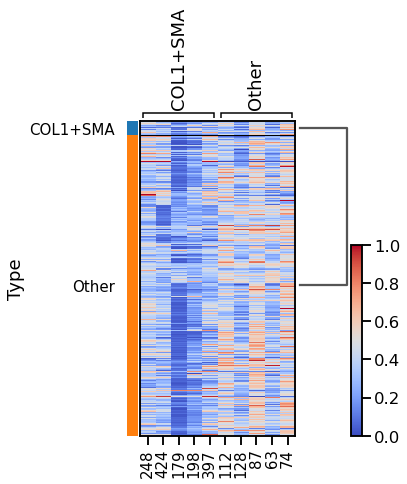

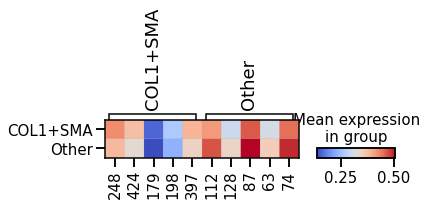

In [113]:
# Extract ion count for cell type
type_names = [ 'CD68', 'CD4', 'CD20', 'CD8', 'GranzymeB', 'Ki67', 'CD3', 'PanK+ECad', 'COL1+SMA']
marker_names = [['CD68'], ['CD4'], ['CD20'], ['CD8'], ['GranzymeB'], ['Ki67'], ['CD3'], ["PanKeratin", "ECadherin"], ['COL1', 'SMA']]

for t,m in zip(type_names, marker_names):
    adata_SIMS = adata[:, SIMS_masses]
    
    # Type dict
    type_dict = {'0': 'Other', '1': t}
    
    # Check cancer vs stroma region
    df = pd.DataFrame(adata_IMC.X, columns=adata_IMC.var_names)
    df['Type'] = '0'
    df.loc[(df[m]>2.5).any(1), 'Type'] = '1'
    
    # Get SIMS data 
    adata_SIMS.obs['Type'] = df.Type.tolist()
    adata_SIMS.obs['Type'] = (
        adata_SIMS.obs['Type']
        .map(type_dict)
        .astype("category")
    )
    adata_SIMS.uns['Type_colors'] = sc.pl.palettes.vega_10_scanpy[:len(np.unique(adata_SIMS.obs['Type']))]
    
    # Get diff
    sc.tl.rank_genes_groups(adata_SIMS, 'Type', method='wilcoxon', key_added = "wilcoxon")
    sc.pl.rank_genes_groups_heatmap(adata_SIMS, n_genes=5, key="wilcoxon", groupby="Type", show_gene_labels=True, cmap='coolwarm',)
    sc.pl.rank_genes_groups_matrixplot(adata_SIMS, n_genes=5, key="wilcoxon", groupby="Type", cmap='coolwarm',)
    dedf = sc.get.rank_genes_groups_df(adata_SIMS, group=None, key='wilcoxon')
    
    path = data_dir / "de" / f'{experiment}_{t}.csv'
    dedf.to_csv(path, index=False)

# Get df

In [114]:
dfs = []
for (dirpath, dirnames, filenames) in os.walk(data_dir / "de"):
    for name in sorted(filenames):
        if experiment in name:
            print(name)
            df = pd.read_csv(os.path.join(dirpath, name))
            dfs.append(df)
            
df = pd.concat(dfs)

Lung_CD20.csv
Lung_CD3.csv
Lung_CD4.csv
Lung_CD68.csv
Lung_CD8.csv
Lung_Col1+SMA.csv
Lung_GranzymeB.csv
Lung_Ki67.csv
Lung_PanK+ECad.csv


In [115]:
df = df[df.group != 'Other']
df.names = df.names.astype(str)
df = df[df.names != '1']

In [116]:
df

,group,names,scores,logfoldchanges,pvals,pvals_adj
1,CD20,279,8.951543,0.342182,3.505465e-19,8.281661e-18
2,CD20,436,8.732501,0.363325,2.491027e-18,5.231156e-17
3,CD20,544,8.080726,0.315796,6.438252e-16,1.014025e-14
4,CD20,479,8.029354,0.336372,9.798684e-16,1.424578e-14
5,CD20,273,7.883726,0.280548,3.177600e-15,4.289760e-14
...,...,...,...,...,...,...
372,PanK+ECad,190,-3.407844,-0.094047,6.547823e-04,6.513361e-03
373,PanK+ECad,162,-3.543062,-0.086099,3.955094e-04,4.152849e-03
374,PanK+ECad,66,-3.691047,-0.058033,2.233331e-04,2.657419e-03
375,PanK+ECad,225,-3.839986,-0.107284,1.230416e-04,1.788835e-03


In [117]:
fold_change_masses = df[df.scores>6].names.unique()

In [118]:
fold_change_masses = fold_change_masses.astype(int)
fold_change_masses.sort()

In [119]:
# Extract ion count for cell type
type_names = [ 'CD68', 'CD4', 'CD20', 'CD8', 'GranzymeB', 'Ki67', 'CD3', 'PanK+ECad', 'COL1+SMA']
marker_names = [['CD68'], ['CD4'], ['CD20'], ['CD8'], ['GranzymeB'], ['Ki67'], ['CD3'], ["PanKeratin", "ECadherin"], ['COL1', 'SMA']]

# Type dict
type_dict = {'0': 'Other',
            '1': type_name,
            }

# Check cancer vs stroma region
df = pd.DataFrame(adata_IMC.X, columns=adata_IMC.var_names)

df_SIMS_list = []
for t,m in zip(type_names, marker_names):
    print(t, m)
    index = (df[m]>2.5).any(1)
    adata_SIMS_subset = adata_SIMS[index, adata_SIMS.var_names.isin(fold_change_masses.astype(str))]
    df_SIMS = pd.DataFrame(adata_SIMS_subset.X, columns=fold_change_masses.astype(str))
    df_SIMS['Type'] = t 
    df_SIMS_list.append(df_SIMS)
    
df_SIMS = pd.concat(df_SIMS_list)

CD68 ['CD68']
CD4 ['CD4']
CD20 ['CD20']
CD8 ['CD8']
GranzymeB ['GranzymeB']
Ki67 ['Ki67']
CD3 ['CD3']
PanK+ECad ['PanKeratin', 'ECadherin']
COL1+SMA ['COL1', 'SMA']


C:\Users\thu71\AppData\Local\Temp/ipykernel_45100/2060523276.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,5))


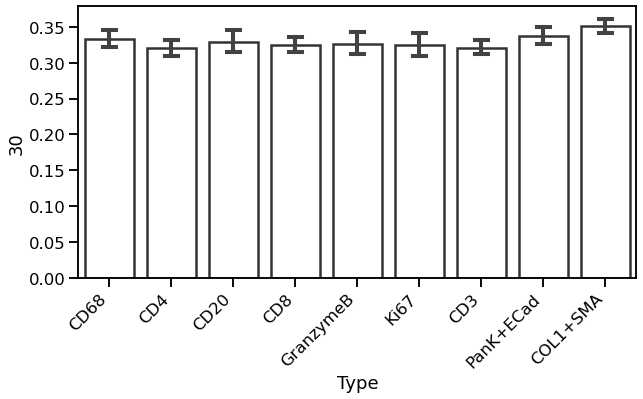

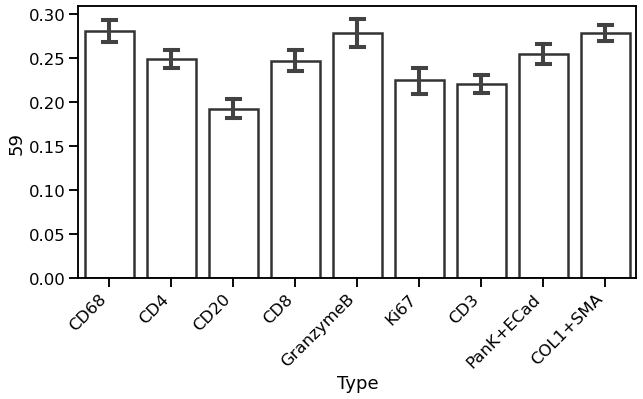

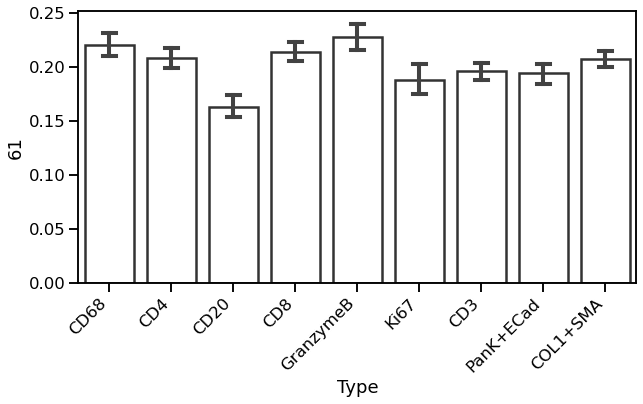

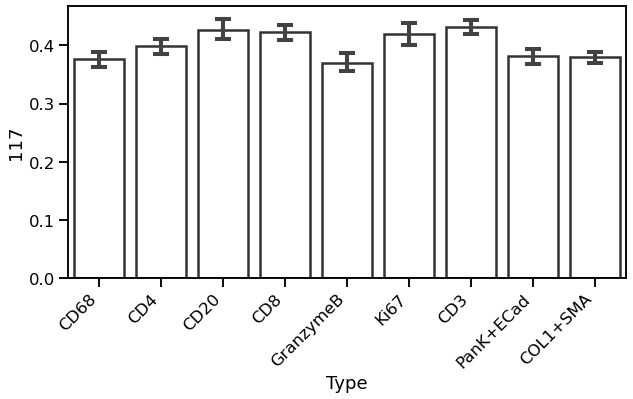

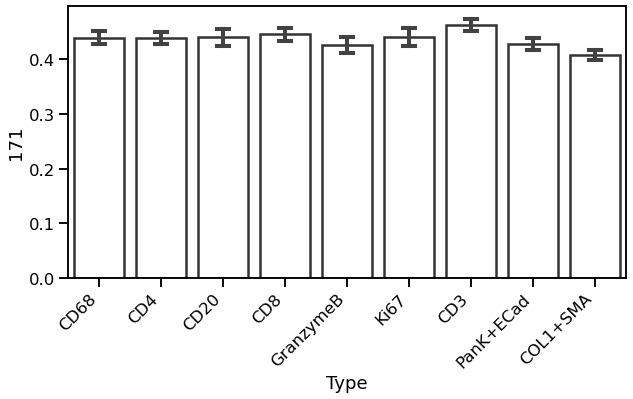

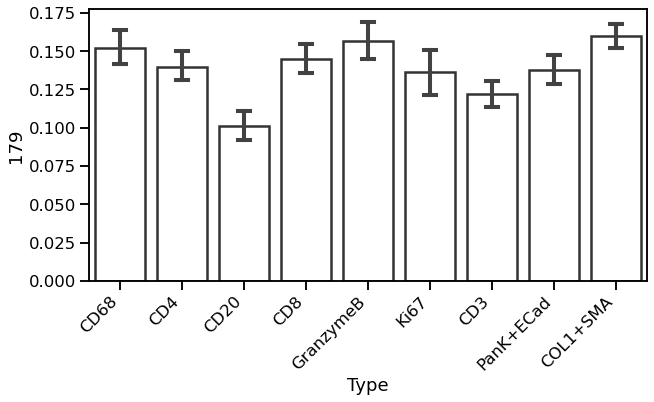

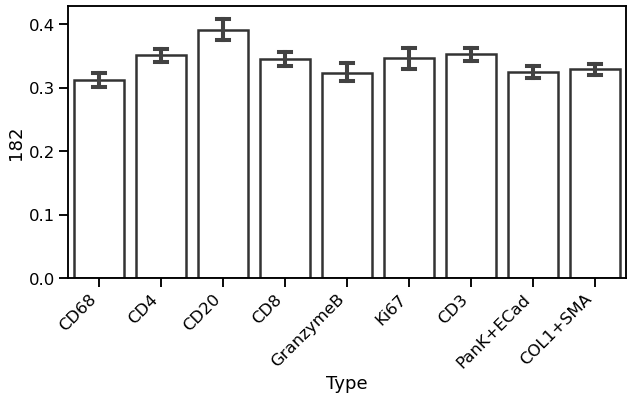

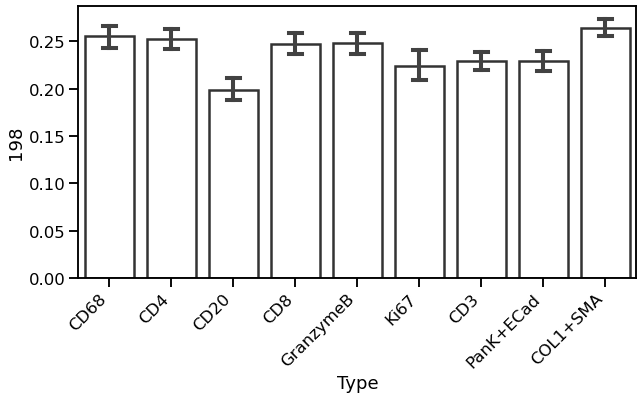

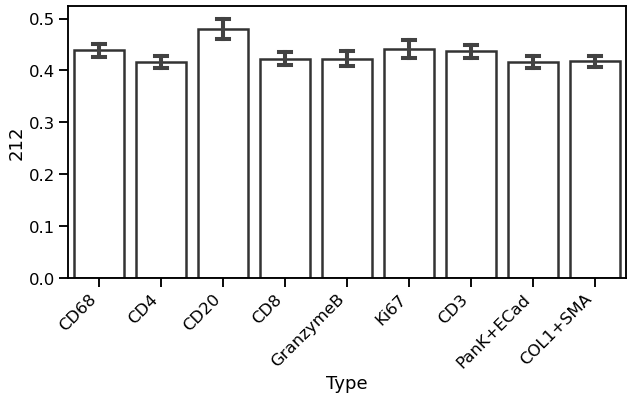

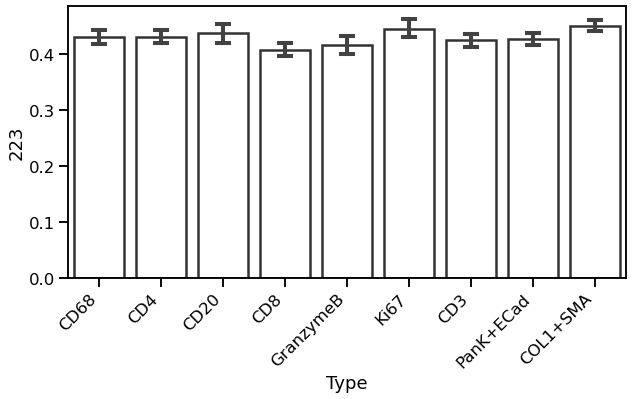

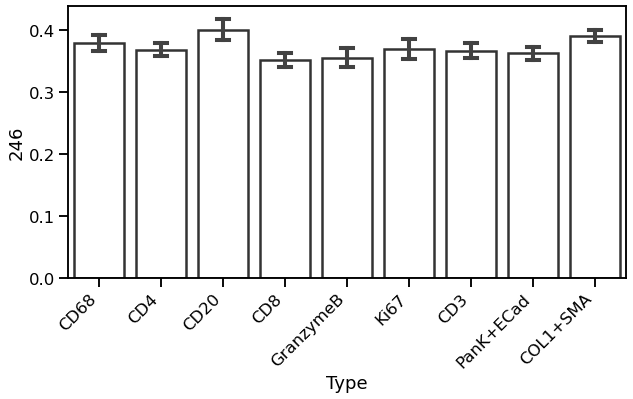

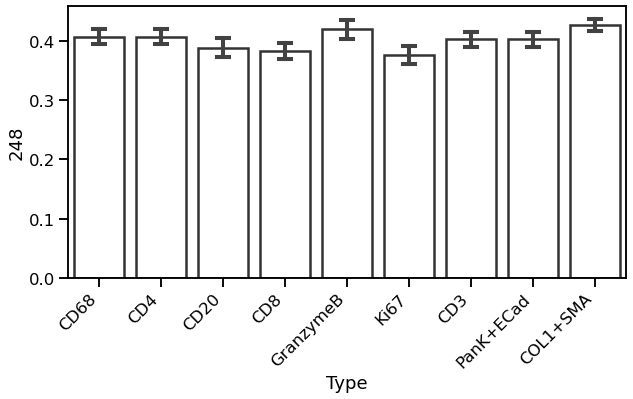

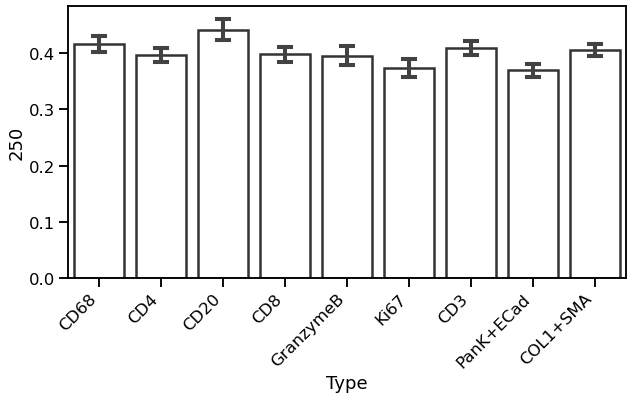

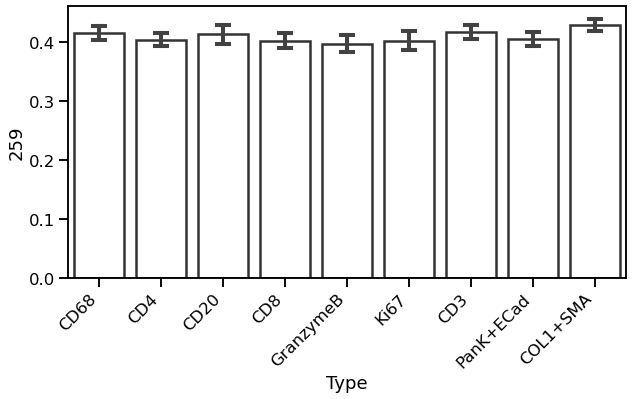

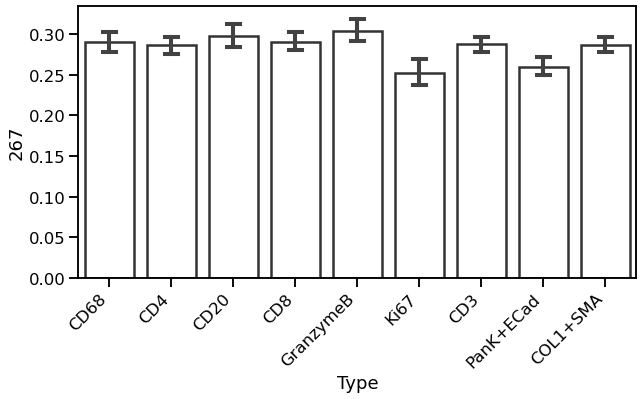

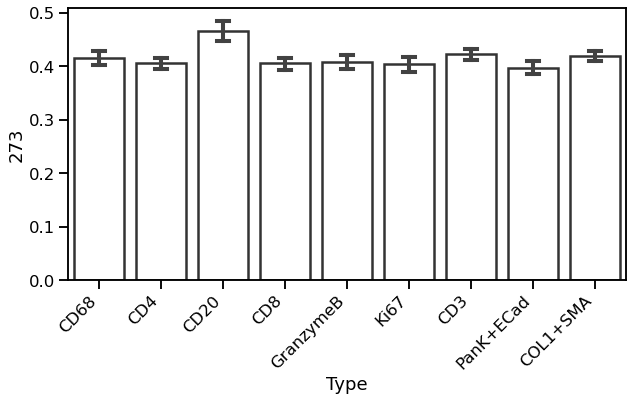

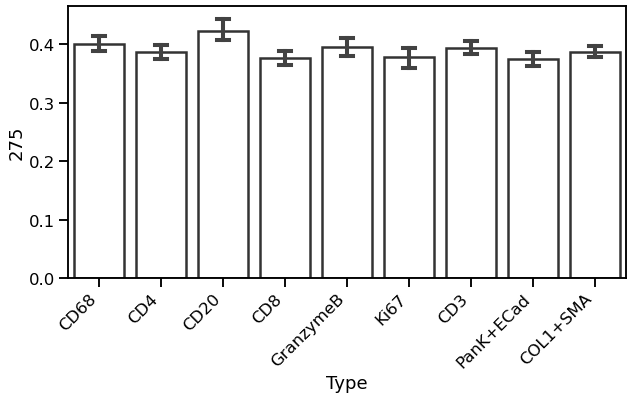

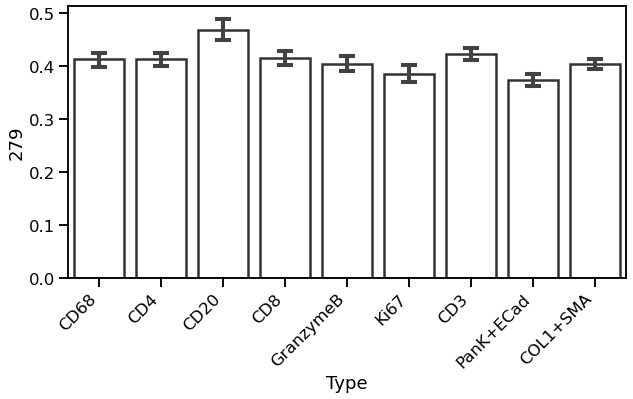

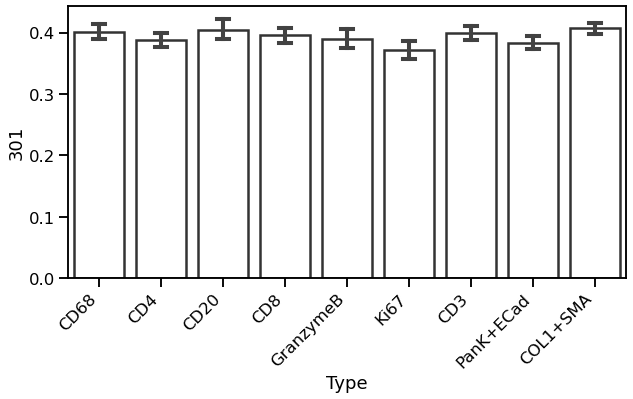

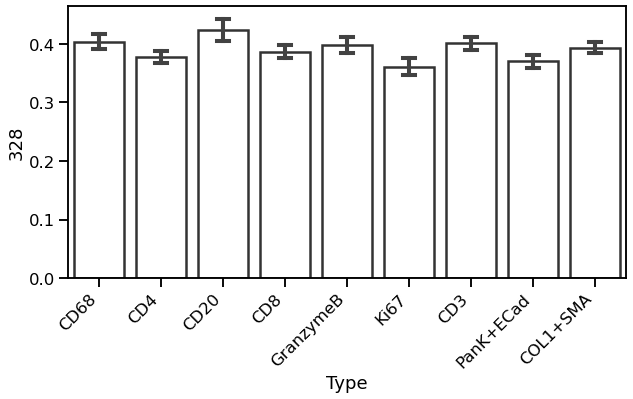

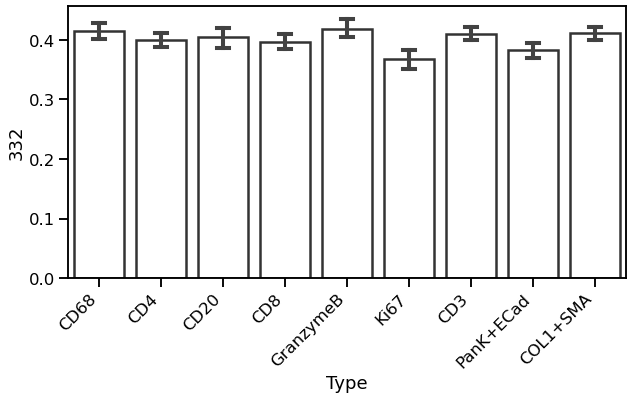

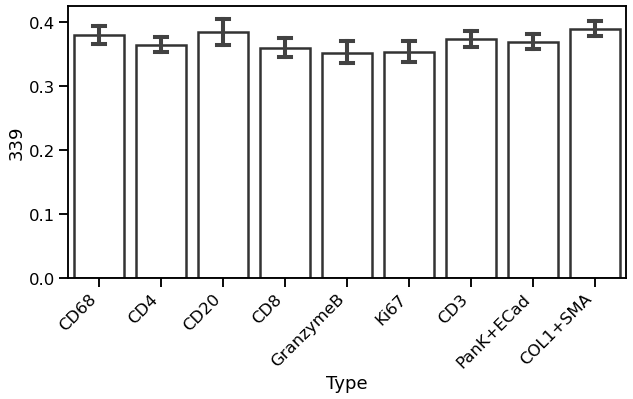

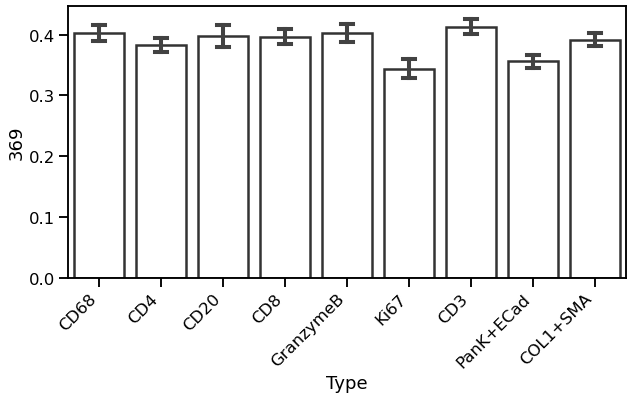

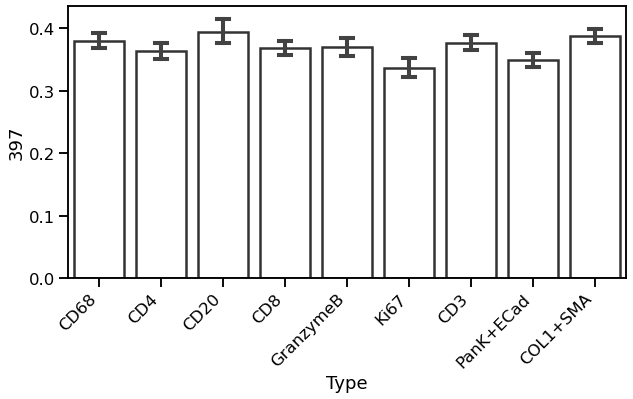

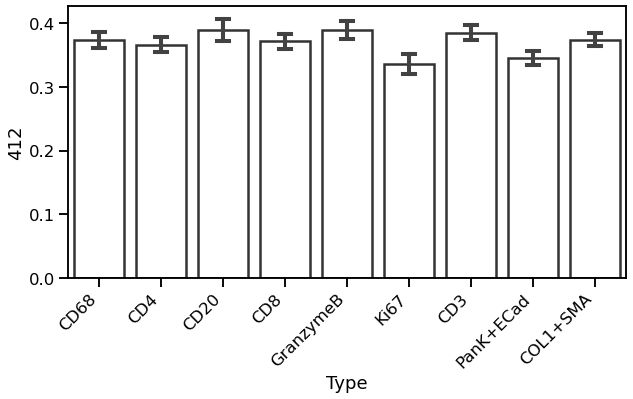

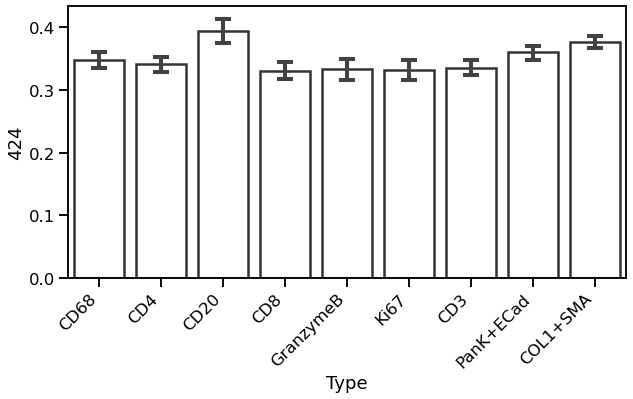

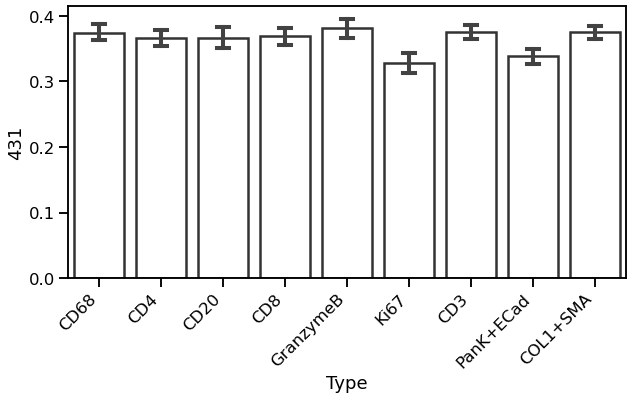

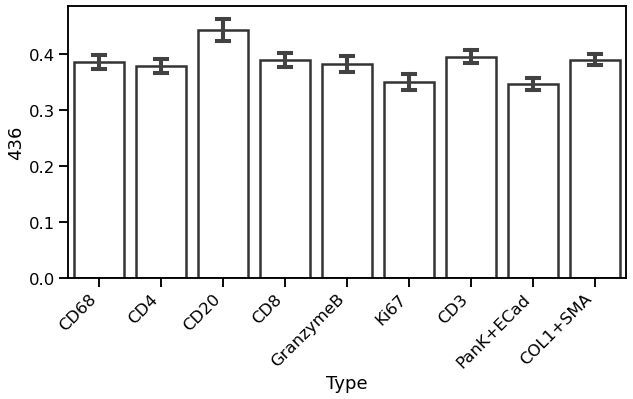

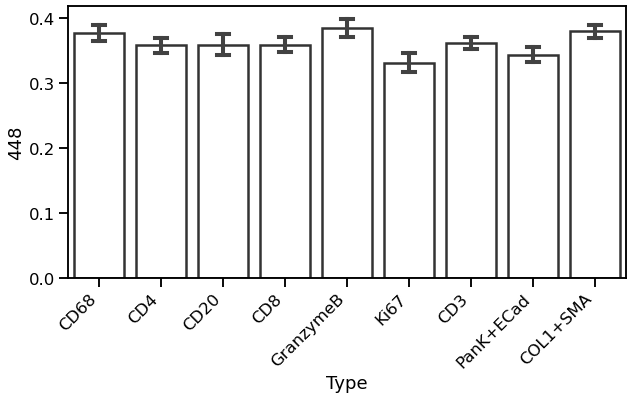

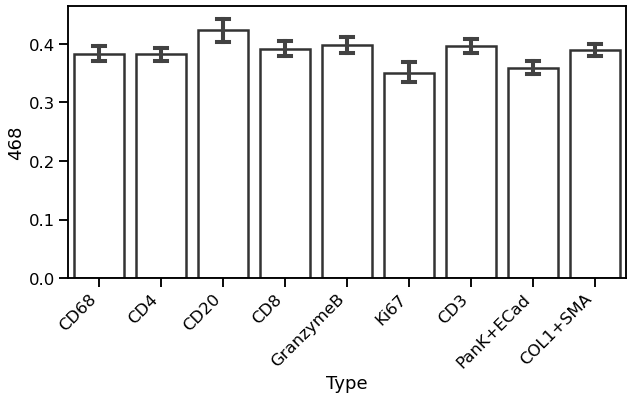

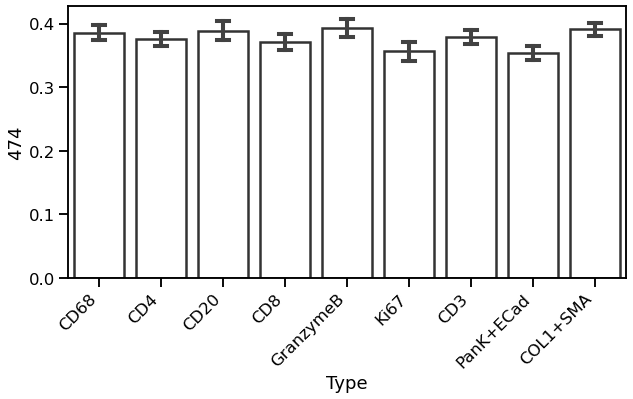

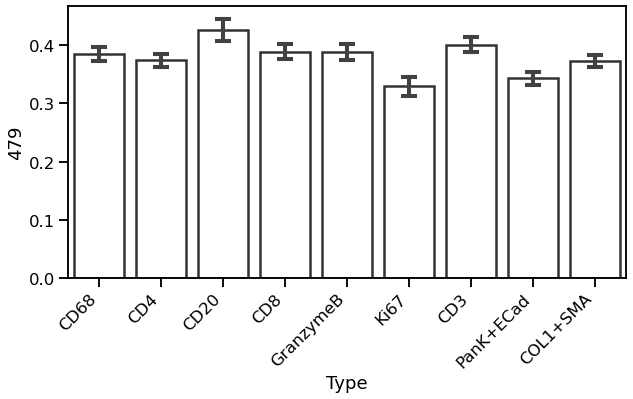

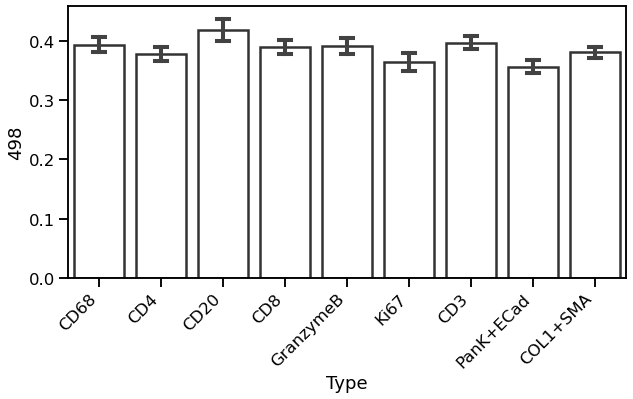

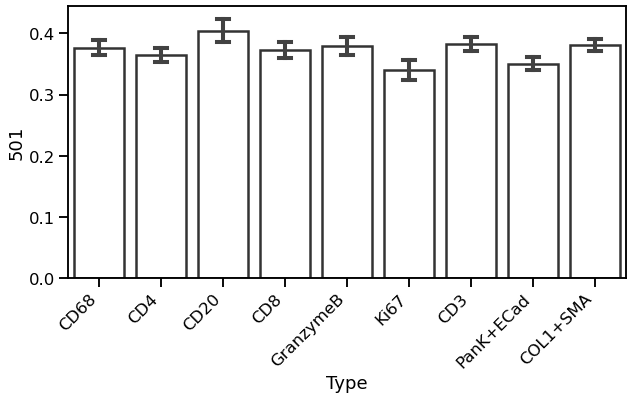

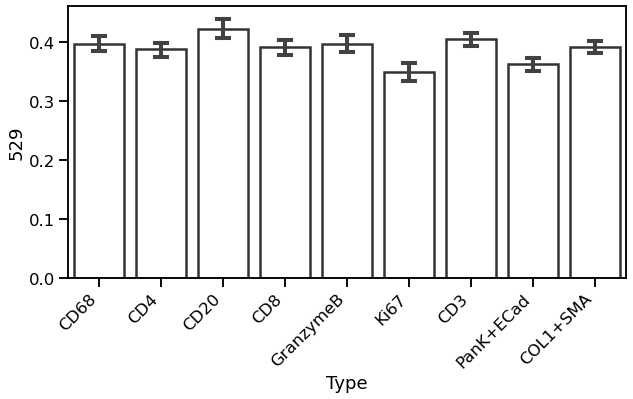

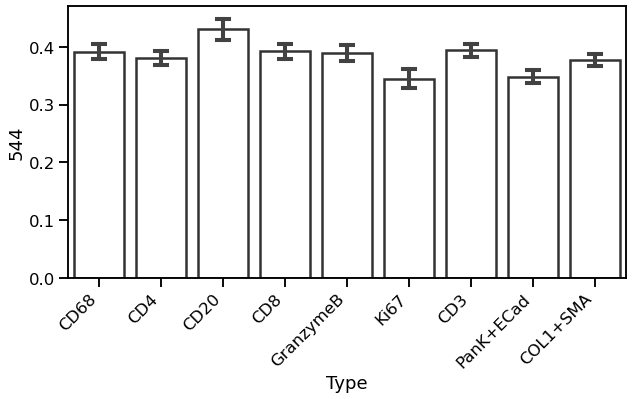

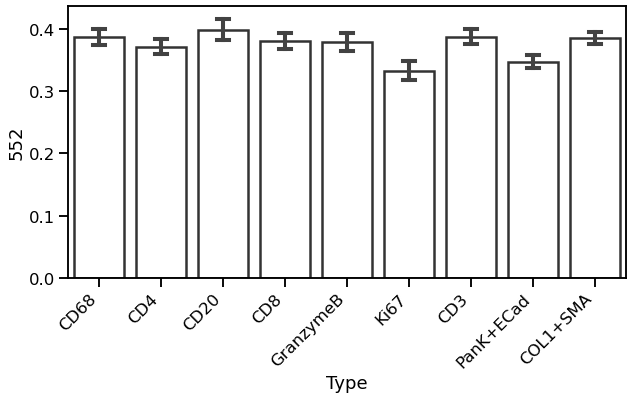

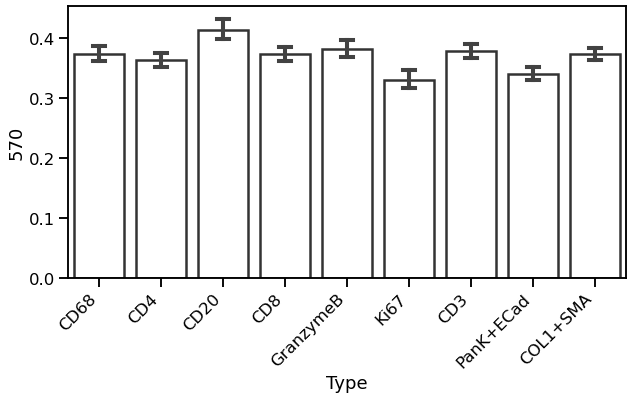

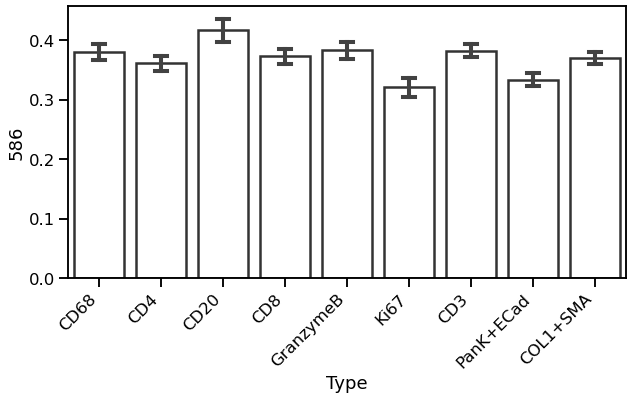

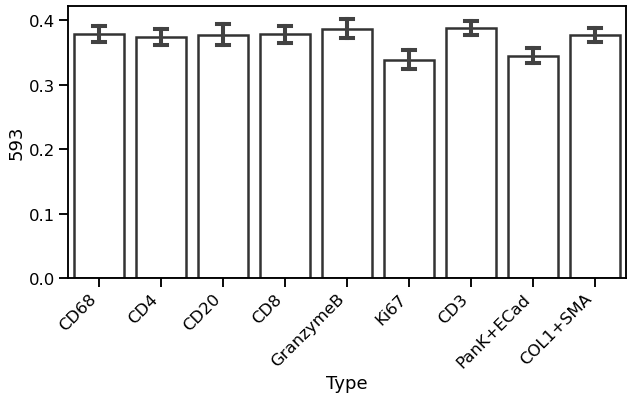

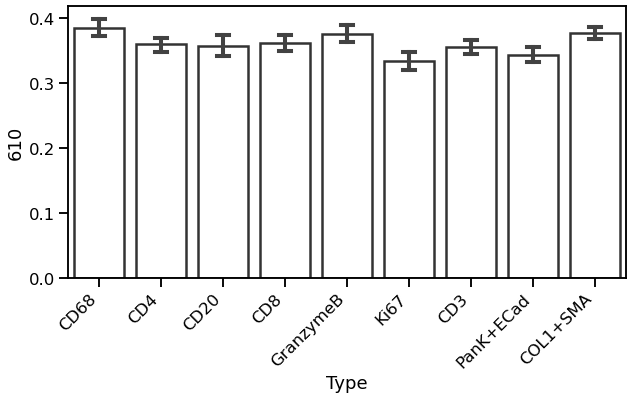

In [123]:
sns.set_context('talk', font_scale=1)
for mz in fold_change_masses:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(data=df_SIMS, x='Type', y=str(mz), ax=ax, capsize=.2, linewidth=2.5, facecolor=(1, 1, 1, 0), edgecolor=".2")
    plt.xticks(rotation = 45, ha='right')

# Print all mz

In [124]:
# Extract ion count for cell type
type_names = [ 'CD68', 'CD4', 'CD20', 'CD8', 'GranzymeB', 'Ki67', 'CD3', 'PanK+ECad', 'COL1+SMA']
marker_names = [['CD68'], ['CD4'], ['CD20'], ['CD8'], ['GranzymeB'], ['Ki67'], ['CD3'], ["PanKeratin", "ECadherin"], ['COL1', 'SMA']]

# Type dict
type_dict = {'0': 'Other',
            '1': type_name,
            }

# Check cancer vs stroma region
df = pd.DataFrame(adata_IMC.X, columns=adata_IMC.var_names)

df_SIMS_list = []
for t,m in zip(type_names, marker_names):
    print(t, m)
    index = (df[m]>2.5).any(1)
    adata_SIMS_subset = adata_SIMS[index, :]
    df_SIMS = pd.DataFrame(adata_SIMS_subset.X, columns=adata_SIMS.var_names)
    df_SIMS['Type'] = t 
    df_SIMS_list.append(df_SIMS)
df_SIMS = pd.concat(df_SIMS_list)

CD68 ['CD68']
CD4 ['CD4']
CD20 ['CD20']
CD8 ['CD8']
GranzymeB ['GranzymeB']
Ki67 ['Ki67']
CD3 ['CD3']
PanK+ECad ['PanKeratin', 'ECadherin']
COL1+SMA ['COL1', 'SMA']


In [159]:
mz_list_all = []
for mz in adata_SIMS.var_names:
    df_SIMS_mz = df_SIMS[[mz, 'Type']]
    df_SIMS_mz_type = df_SIMS_mz.groupby('Type').mean()
    if (df_SIMS_mz_type.values.max()-df_SIMS_mz_type.values.min()) > 0.09:
        mz_list_all.append(mz)
        
mz_lists = np.split(np.array(mz_list_all[1:]), 2)

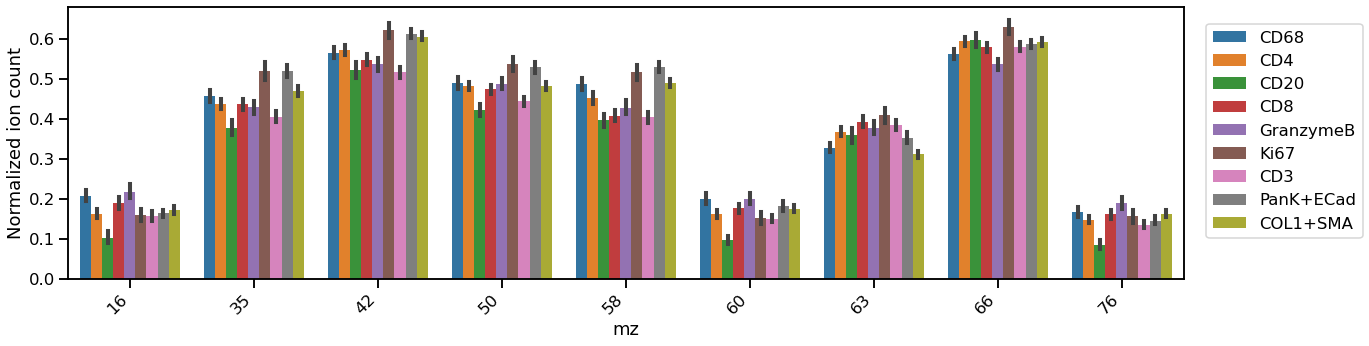

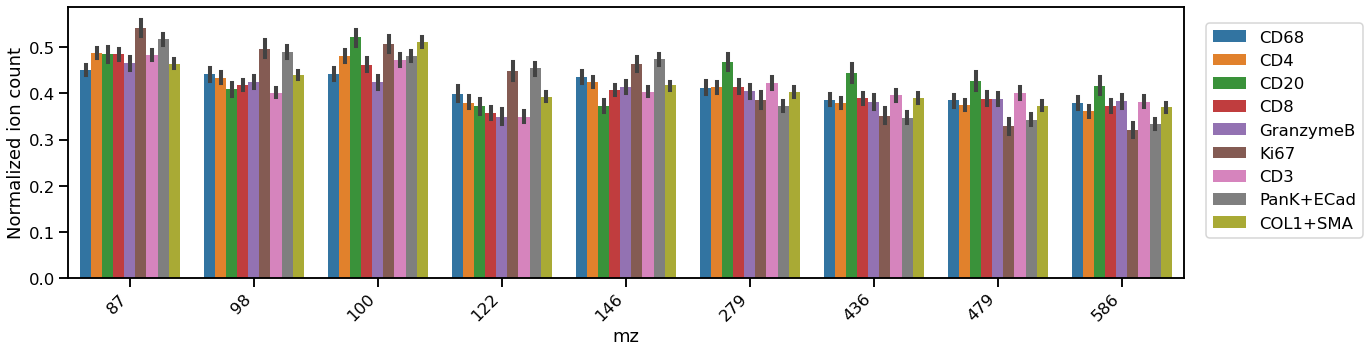

In [157]:
sns.set_context('talk', font_scale=1)

for mz_list in mz_lists:
    df_SIMS_var = (df_SIMS
                   .loc[:,list(mz_list)+['Type']]
                   .melt(id_vars='Type', var_name='mz', value_name='Normalized ion count'))

    fig, ax = plt.subplots(figsize=(20,5))
    sns.barplot(data=df_SIMS_var, hue='Type', x='mz', y='Normalized ion count', ax=ax, palette='tab10')
    plt.xticks(rotation = 45, ha='right')
    plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)


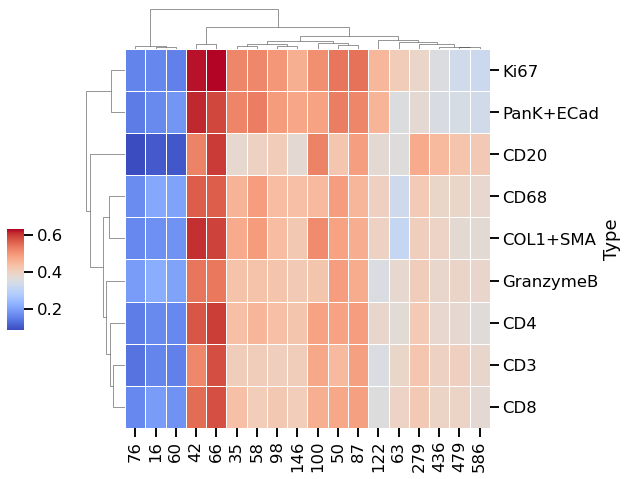

In [178]:
from matplotlib.colors import LogNorm

df_SIMS_var = .loc[:,list(mz_list_all[1:])+['Type']].groupby('Type').mean()

sns.clustermap(df_SIMS_var, cmap='coolwarm', dendrogram_ratio=(.1, .1), 
                   cbar_pos=(-.1, .32, .03, .2),
                   linewidths=.75, figsize=(8, 7))